<a href="https://colab.research.google.com/github/mzhkz/coefont_kana_convert_error_detector/blob/main/0904_detect_kana_yomi_error.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 事前準備
## 必要なパッケージ等を読み込み/割り当て

In [1]:
! pip install mecab-python3 unidic-lite
! pip install plyvel
! pip install sseclient

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 574 kB 5.1 MB/s 
     |████████████████████████████████| 47.4 MB 163 kB/s 
  Created wheel for unidic-lite: filename=unidic_lite-1.0.8-py3-none-any.whl size=47658836 sha256=341bced5998796bfdba956d5012a46b292acd9f5abd0c6e82da9dfa5cc203179
  Stored in directory: /root/.cache/pip/wheels/de/69/b1/112140b599f2b13f609d485a99e357ba68df194d2079c5b1a2
Successfully built unidic-lite
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 693 kB 5.2 MB/s 


In [96]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import requests as reqs
import json
import regex
import plyvel
import pickle
import MeCab
import datetime
from sseclient import SSEClient as EventSource

## 作業ディレクトリ（ファイルの読み込みや保存を行う絶対パス）

In [3]:
APP_WORKDIR = "/content/drive/MyDrive/coefont_kana_converter_error_detector/"

In [4]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


### APIのアクセストークンなど機密情報の管理

In [5]:
secrets = {}
with open(APP_WORKDIR + 'secrets.json') as f:
  secrets = json.load(f)

## データベースのセットアップ（品詞の保存）
* APIのアクセス量を減らすため、過去に変換を行った単語をデータベースに保存し、キャッシュとして利用する。
* 読み書きの早い、Key -> Value型のローカルファイル型データベースである。
* Ethereumのノードの内部ではトランザクションの管理とかでも使われている。
* https://github.com/google/leveldb
* https://plyvel.readthedocs.io/en/latest/

In [57]:
vocab_db = plyvel.DB(APP_WORKDIR + 'vocabs.ldb', create_if_missing=True)
lebels_db = plyvel.DB(APP_WORKDIR + 'lebels.ldb', create_if_missing=True)
checked_db = plyvel.DB(APP_WORKDIR + 'checked.ldb', create_if_missing=True)

dbs = [vocab_db, lebels_db, checked_db]

### パスを間違えたりして再読み込みする場合は以下セルを実行してから上のセルを実行する

In [56]:
for db in dbs:
  db.close()

## 各種依存記号の設定

In [7]:
SYMBOL_READING_POINT = "、" # 句読点
SYMBOL_PUNCTUATION = "。" # 読点
SYMBOL_HALF_SPACE = " " # 半角スペース
SYMBOL_LONG_NOTE = "ー" # 伸ばし棒
SYMBOL_NONE = "" # 空文字
SYMBOL_TAB = "\t" # TAB
SYMBOL_SEMICORON = ";" # SEMICORON

# データソース別のクラス
* 単語中抽出に必要な対象（Webページなど）を管理する
* 名詞の抽出とMeCabによるよみラベルを管理する。

## 要件
*   Webサイトからテキストをスクレイピング（Webサイトごとにテンプレートを作成する）
*   リンクや特殊記号を排除する
*   文章の形態素解析を行い、漢字が含まれている名詞のみを抽出する。



### MecabのWakatiで初期化

In [8]:
wakati = MeCab.Tagger()

### 漢字判定用の正規表現

In [9]:
KANJI_REG_PETERN = regex.compile(r'\p{Script=Han}+')

## ローダー

In [10]:
class DataSource:
  def __init__(self):
    self.vocabs = []
    self.labels = [] 

  def _fetchData(self): # 文章（テキストデータ）を読み込む、ここは各サービスごとに取得の方法が異なるためオーバーライドする。
    pass

  def preprosessing(self, subject):
    handled = self._replaceSymbol(subject) #ここから文字列
    return handled

  def _replaceSymbol(self, subject):
    sentence = subject.replace(SYMBOL_TAB, SYMBOL_NONE)
    return sentence

  def load(self):
    text = self._fetchData()
    text = self.preprosessing(text)
    vocabs, labels = self._analysis(text)
    self.vocabs = vocabs
    self.labels = labels 

  def _analysis(self, subject):
    result = wakati.parse(subject) # 形態素解析分析 tab分けで結果が出てくる
    vocabs = [line.split(SYMBOL_TAB) for line in result.splitlines()]
    nouns = [vocab_data for vocab_data in vocabs if len(vocab_data) >= 4 and "名詞" in vocab_data[4][0:2] and KANJI_REG_PETERN.search(vocab_data[0])] # 漢字を含む名詞のみ抽出
    nouns, labels = [noun[0] for noun in nouns],  [noun[2] for noun in nouns] # 品詞とかな変換を分割
    unique_nouns = []
    unique_labels = []
    for noun, label in zip(nouns, labels):
      if noun not in unique_nouns:
        unique_nouns.append(noun)
        unique_labels.append(label)
    return unique_nouns, unique_labels # 名詞とMeCabによるかな変換を取得

  def save(self, new_count=False):
    reg_vocab_count = 0
    for vocab, label in zip(self.vocabs, self.labels):
      binary_key = vocab.encode("utf-8") # key for level db
      binary_lebel = label.encode("utf-8") # key for level db
      if new_count and vocab_db.get(binary_key) is None:
        reg_vocab_count +=1
      vocab_db.put(binary_key, binary_lebel)
    return reg_vocab_count

## 各種サービスなど、オケージョンごとのローダー

ローダーの対象
*   note.com （記事サービス）
*   wikipedia.org (辞書)
*   ローカルファイル
*   変数



### 変数からテキストを読み込む

In [11]:
class ArrayDataSource(DataSource):
  def __init__(self, vocabs, labels):
    super().__init__()
    self.vocabs = vocabs
    self.labels = labels 

  def load(self):
    pass

  def _analysis(self, subject):
    pass

  def _fetchData(self):
    return "".self.vocabs

### ローカルのテキストファイルからテキストを読み込む（バイナリファイル未対応）

In [12]:
class LocalDataSource(DataSource):
  def __init__(self, file_path):
    super().__init__()
    self.file_path = file_path

  def _fetchData(self):
    with open(self.file_path) as f:
      lines = f.readlines()
      self.source = "".join(lines)
    return self.source

### Note API v2
note.comから記事を取得する

In [13]:
class NoteDataSource(DataSource):
  def __init__(self, note_article_key):
    super().__init__()
    self.note_article_key = note_article_key

  def _fetchData(self):
    url = "https://note.com/api/v1/notes/{}".format(self.note_article_key)
    response = reqs.get(url=url)
    text = response.text
    response_json = json.loads(text)
    return response_json["data"]["body"]

### Wikipedia

https://ja.wikipedia.org/w/api.php?format=json&action=query&prop=extracts&exintro&explaintext&redirects=1&titles=%E6%85%B6%E6%87%89%E7%BE%A9%E5%A1%BE%E5%A4%A7%E5%AD%A6

In [44]:
class WikipediaDataSource(DataSource):
  def __init__(self, title):
    super().__init__()
    self.title = title

  def _fetchData(self):
    url = "https://ja.wikipedia.org/w/api.php?format=json&action=query&prop=extracts&exintro&explaintext&redirects=1"
    params = {
        "titles": self.title,
    }
    response = reqs.get(url=url, params=params)
    text = response.text
    response_json = json.loads(text)
    return list(response_json["query"]["pages"].values())[0].get("extract", "")

### 一時開発用データセット

In [33]:
class TempDataSource(DataSource):
  def __init__(self):
    super().__init__()

  # loadを上書き
  def load(self):
    note_articles_id = [
      "n4ece27ed112b",
      "n0433243163f5",
      "n2861fae03861",
      "n6965c22952ac",
      "ndf3aed673e7f",
      "n766dc842145d",
      "ndace078a3cb1"
    ]
    data_sources = [NoteDataSource(id) for id in note_articles_id]
    nouns = []
    labels = []
    for data_source in data_sources:
      data_source.load()
      nouns = nouns + data_source.vocabs
      labels = labels + data_source.labels
    # self.vocabs = nouns[:83]
    # self.labels = labels[:83]
    self.vocabs = nouns
    self.labels = labels

## 各種ローダーのテスト

In [16]:
test01_note_datasource = NoteDataSource(note_article_key="n4ece27ed112b")
test01_note_datasource.load()

print(test01_note_datasource.vocabs)
print(test01_note_datasource.labels)

test01_note_datasource.save(new_count=True)

['大学', '入学', '時代', '人間', '選択', '幸せ', '伝播', '自分', '不安', '勉強', '自負', '技術', '修得', '人', '一', '倍', '熱量', '努力', '実際', '学生', '身分', '個人', '開発', '仕事', '社会', '感覚', '自身', '生活', '半ば', '先生', '方', '言葉', '魂', '所属', '研究', '会', '友人', '価値', '方向', '言語', '学び', '本質', '事実', '記事', '今後', '記録', '執筆', '迷走', '逆', '体得', '宝物', '月', '終わり', '勢い', '文中', '箇所', '筆者', '教え', '理解', '問題', '発見', '解決', '最近', '以外', '中等', '教育', '学校', '反面', '事例', '背景', '論点', '整理', '視点', '在学', '骨', '髄', '変容', '意見', '参考', '本当', '少数', '解釈', '考え', '注意', '公式', '見解', '一切', '独断', '偏見', '構成', '主張', '念頭', '進学', '意図', '特徴', '理系', '文系', '区別', '自由', '分野', '横断', '内外', '耳', '着眼', '点', '縦割り', '意識', '必要', '対応', '世界', '帰着', '複雑', '議論', '担保', '題材', '享受', '世の中', '発展', '環境', '注目', '例', '導入', '暮らし', '以前', '単位', '失敗', '典型', '話題', '目的', '不在', '情報', '恩恵', '問い', '探索', '方法', '論', '先行', '取り組み', '事', '欲望', '合理', '道筋', '分断', '限り', '人々', '単体', '寄与', '根幹', '後者', '先導', '人材', '育成', '力', '最終', '身', '年間', '結果', '創出', '伝達', '付加', '創造', '連鎖', '今', '命題', '量産', '輸出', '変化', '通り', '知識

0

In [17]:
test01_wiki_datasource = WikipediaDataSource(title="慶應義塾大学")
test01_wiki_datasource.load()

print(test01_wiki_datasource.vocabs)
print(test01_wiki_datasource.labels)

test01_wiki_datasource.save(new_count=True)

['慶應', '義塾', '大学', '英語', '東京', '都', '港', '区', '三田', '丁目', '番', '号', '本部', '日本', '私立', '年', '創立', '設置', '略称', '慶大', '應', '旧', '字体', '報道', '慶応', '表記']
['ケイオウ', 'ギジュク', 'ダイガク', 'エイゴ', 'トウキョウ', 'ト', 'ミナト', 'ク', 'ミタ', 'チョウメ', 'バン', 'ゴウ', 'ホンブ', 'ニッポン', 'シリツ', 'ネン', 'ソウリツ', 'セッチ', 'リャクショウ', 'ケイダイ', '應', 'キュウ', 'ジタイ', 'ホウドウ', 'ケイオウ', 'ヒョウキ']


0

# コンバーターのクラス

* 漢字をかな変換するコンバータ
* クラスとして機能を丸めることで複数のコンバーターの差異を吸収する。コンバーターを適用する順序を入れ替えるなど

In [26]:
class BaseConverter:
  def __init__(self, conveter_name):
    self.converter_name = conveter_name
    self.split_code = SYMBOL_SEMICORON

  def preprosessing(self, subject):
    return subject

  def convert(self, vocabs):
    sentence = SYMBOL_PUNCTUATION.join(vocabs) + SYMBOL_PUNCTUATION # 各単語をsplit tokenを付けて文字列化
    result = self._execute_api(sentence)
    # result = result.replace(SYMBOL_PUNCTUATION, SYMBOL_NONE)
    converted_vocabs = [self.preprosessing(vocab) for vocab in result.split(SYMBOL_PUNCTUATION)] #文字列をsplit tokenを用いて単語ごとにリスト化
    return converted_vocabs

  def get_indexkey(self, noun):
    return "{}_{}".format(self.converter_name, noun).encode("utf-8")

## CoeFont API (target)
* CoefontのAPIのアクセス方法とアクセスキーが変わり次第、実装する

In [27]:
SYMBOL_TRIGGER_1 = [
        ["オ", "コ", "ソ", "ト", "ノ", "ホ", "モ", "ヨ", "ロ", "ヲ"], # o
        ["エ", "ケ", "セ", "ネ", "ヘ", "メ", "レ"], # e removed テ
        ["ア", "カ", "サ", "タ", "ナ", "ハ", "マ", "ラ", "ヤ", "ラ", "ワ"], # a
        ["ュ", "ョ"],
        ["ゴ", "ゾ", "ド", "ボ", "ポ", "ゴ", "ゾ", "ド", "ボ"],
        ["ギ", "ジ", "ヂ", "ビ", "ピ", "ギ", "ジ", "ジ", "ビ","ピ"],
        ["イ", "キ", "シ", "千", "二", "ヒ", "ミ", "リ"], # i 
        ["ウ", "ク", "ス", "ツ", "ヌ", "フ", "ム", "ユ", "ル"] # u
        ]

SYMBOL_TRIGGER_2 = [
        ["ウ"],
        ["イ"],
        ["ア"],
        ["ウ"],
        ["ウ"],
        ["イ"],
        ["イ"],
        ["ウ"]
        ]

class CoeFontConverter(BaseConverter):
  def __init__(self):
    super().__init__("coefont")

  def _execute_api(self, sentence):
    # coefontの実装
    url = secrets["coefont_api_endpoint"]
    params = {
        "text": sentence,
    }

    r = reqs.post(url=url, data=params)
    response_text = r.text
    print("** CoeFont API:", response_text)
    response_json = json.loads(response_text)
    return response_json["yomi"]

  def preprosessing(self, subject):
    list_kat_subject = list(subject)
    kat_subject_size = len(list_kat_subject)-1
    idkc = 0
    while  idkc < kat_subject_size:
      kat_char_pointer = list_kat_subject[idkc]
      kat_char_next = list_kat_subject[idkc+1]
      if kat_char_next == SYMBOL_LONG_NOTE:
         for ids, symbols in enumerate(SYMBOL_TRIGGER_1):
           if kat_char_pointer in symbols:
               list_kat_subject[idkc+1] = SYMBOL_TRIGGER_2[ids][0]
               idkc+=1
      idkc+=1
    return "".join(list_kat_subject)

## 一時的開発用コンバータ

*   CoeFontの出力を想定して、特定の単語を入力した静的な結果を返却する



In [28]:
class TempCoeFontConverter(CoeFontConverter):
  def __init__(self):
    super().__init__()

  def _execute_api(self, sentence):
    # coefontの実装
    # 一時的な実装 決まった文章を返す
    source = None
    with open(APP_WORKDIR + "response_commma.json") as f:
      source = json.load(f)
    return source["yomi"]

## Goo API
* かな変換APIを使用する。
* ドキュメントはこちら
  * https://labs.goo.ne.jp/api/jp/hiragana-translation/

In [78]:
class GooConverter(BaseConverter):
  def __init__(self, app_id):
    super().__init__("goo")
    self.app_id = app_id

  def _execute_api(self, sentence):
    url = "https://labs.goo.ne.jp/api/hiragana"
    params = {
        "app_id": self.app_id,
        "sentence": sentence,
        "output_type": "katakana"
    }

    headers = {'Content-Type': 'application/json'}

    r = reqs.post(url=url, data=params)
    response_text = r.text
    print("** Goo API:", response_text)
    response_json = json.loads(response_text)
    return response_json.get("converted", "")

  def preprosessing(self, subject):
     return subject.replace(SYMBOL_HALF_SPACE, SYMBOL_NONE)

## Yahoo API
* かな変換APIを使用する。
* ドキュメントはこちら
  * https://developer.yahoo.co.jp/webapi/jlp/furigana/v2/furigana.html
  * https://developer.yahoo.co.jp/webapi/jlp/sample/sample10.html

In [79]:
class YahooConverter(BaseConverter):
  def __init__(self, app_id):
    super().__init__("yahoo")
    self.app_id = app_id

  def _execute_api(self, sentence):
    url = "https://jlp.yahooapis.jp/FuriganaService/V2/furigana"
    params = {
      "id": "abc",
      "jsonrpc": "2.0",
      "method": "jlp.furiganaservice.furigana",
      "params": {
        "q": sentence,
      }
    }
    headers = {
        "Content-Type": "application/json",
        "User-Agent": "Yahoo AppID: {}".format(self.app_id),
    }

    params = json.dumps(params).encode()
    r = reqs.post(url=url, data=params, headers=headers)
    response_text = r.text
    print("** Yahoo API:", response_text)
    response_json = json.loads(response_text)
    kana_list = [word.get("furigana", word.get("surface", "ERR")) for word in response_json["result"]["word"]]
    return SYMBOL_NONE.join(kana_list)

  def _hiragana_to_katakana(self, target):
    return ''.join([chr(n+96) if (12352 < n and n < 12439) or n==12445 or n==12446 else chr(n) for n in [ord(c) for c in target]])

  def preprosessing(self, subject):
    subject = self._hiragana_to_katakana(subject)
    subject = subject.replace(SYMBOL_HALF_SPACE, SYMBOL_NONE)
    return subject

# データソース毎に読みの検証を行う
* コンバータを用いてCoeFontの単語出力と比較を行う。
* 比較の結果、不一致だった場合は他のコンバーターにおいても比較を行い、正解ラベルを付与できるよう分布を収束させる。

In [123]:
class ConverterCompetition:
  def __init__(self, converters):
    self.converters = converters

  # 指定されたデータソースをもとに、指定されたコンバータでかな変換を行う。
  # 名詞と、かな変換の結果をタプル型で返却する。
  def _convert_all_on(self, data_source, converter_id, reset_cache=False):
    vocabs = data_source.vocabs
    converter = self.converters[converter_id] # 指定されたコンバータを取得
    db_keys = [converter.get_indexkey(vocab) for vocab in vocabs] # 名詞をデータベースに対応するIDに変換

    caches = []
    if reset_cache:
      caches = [None for db_key in db_keys] # キャッシュ削除
    else:
      caches = [lebels_db.get(db_key) for db_key in db_keys] # データベースに問い合わせる。キャッシュがなかったらNoneが設定される

    entred_vocab = [vocab for idv, vocab in enumerate(vocabs) if caches[idv] is None] # キャッシュが存在せず、新しくAPIから取得する名詞一覧
    new_yomi_labels = [] # 変換された読みを保存するためのリスト

    if (len(entred_vocab) > 0): # 新しくAPIからかな変換を取得する必要があるか確かめる
      new_yomi_labels = converter.convert(entred_vocab)

    for vocab, label in zip(entred_vocab, new_yomi_labels):
      lebels_db.put(converter.get_indexkey(vocab), label.encode("utf-8")) # APIから取得したよみをデータベースに保存（キャッシュとなり、以降これが使われる）

    yomi_labels = []
    iter_new_yomi_labels = iter(new_yomi_labels)
    for idc, cache in enumerate(caches):
      if cache:
        yomi_labels.append(cache.decode("utf-8")) # キャッシュ（db）にある場合はキャッシュから取得
      else:
        yomi_labels.append(next(iter_new_yomi_labels)) # ない場合は、先ほど変換した結果から取得
    
    return vocabs, yomi_labels

  # 指定されたデータソースをもとに、指定されたコンバータ間で結果を比較する
  # 不一致の単語とその結果をタプル型で返却する
  def compete_to(self, data_source, subject_converter_id, target_converter_id, reset_cache=False):
    vocabs, yomi_labels_0 = self._convert_all_on(data_source, subject_converter_id, reset_cache)
    _, yomi_labels_1 = self._convert_all_on(data_source, target_converter_id, reset_cache)

    errors = []
    for idn, noun in enumerate(vocabs):
      yomi_label_0 = yomi_labels_0[idn]
      yomi_label_1 = yomi_labels_1[idn]
      if yomi_label_0 != yomi_label_1: # 読みラベルを比較して、一致しなかった場合errorsに追加
         errors.append([noun, yomi_label_0, yomi_label_1])

    return errors

  # 指定されたデータソースをもとに、Mecabと指定されたコンバータとの結果を比較する
  # 不一致の単語とその結果をタプル型で返却する
  def compete_to_mecab(self, data_source, converter_id=0, reset_cache=False):
    vocabs, yomi_labels = self._convert_all_on(data_source, converter_id, reset_cache)

    errors = []
    for idn, noun in enumerate(vocabs):
      yomi_label = yomi_labels[idn]
      mecab_label = data_source.labels[idn]
      if yomi_label != mecab_label: # 読みラベルを比較して、一致しなかった場合errorsに追加
         errors.append([noun, yomi_label+":{}".format(self.converters[converter_id].converter_name), mecab_label + ":mecab"]) # 単語, 比較対象の出力, mecabの出力

    return errors

  # 指定されたデータソースををもとに、すべてのコンバータの結果を表示する、
  # ただし、対象はMeCabとCoeFontの比較で不一致の名詞のみ
  # 不一致の単語に対する各コンバーター結果を辞書型で返却する。
  def compete_to_all(self, data_source, reset_cache=False):
    # MeCabのエラー抽出
    errors_0 = self.compete_to_mecab(data_source, 0, reset_cache) # mecabとconverter 0を比較する
    errors = {error_0[0]:[error_0[1], error_0[2]] for error_0 in errors_0} #エラーを格納するdict 
    errors_0_nouns = errors.keys()

    # MeCabと一致しなかった単語を外部APIにかける、
    for idc in range(1, len(self.converters)):
      array_dataset = ArrayDataSource(errors_0_nouns, []) # 対象の単語をデータソース化
      vocabs, yomi_labels = self._convert_all_on(array_dataset, idc, reset_cache) #APIの結果を取得
      for checked_vocab, checked_label in zip(vocabs, yomi_labels):
        errors[checked_vocab].append(checked_label)
    return errors


# 誤字の検出と、複数APIを用いた結果の分布を取得する

### データソースのロード

In [34]:
test_04_datasource = TempDataSource()
test_04_datasource.load() # 単語の分割とMeCabのラベルを取得する

# データソースの一致を確認
test_04_result = TempCoeFontConverter().convert([])
print(len((test_04_datasource.vocabs)), len(test_04_result))
print(test_04_result[0], test_04_datasource.vocabs[0])

1705 2922
ダイガク 大学


### コンバーターの初期化と比較
*   MeCabとCoeFontの出力を比較する
*   比較が一致しなかった場合、他のコンバータで検証する。
*   すべてのコンバータの出力をdict型（keyに名詞、valueに各コンバーターの結果の配列）にまとめる



In [ ]:
test_04_converters = [TempCoeFontConverter(), GooConverter(app_id=secrets["goo_api_id"]), YahooConverter(app_id=secrets["yahoo_app_id"])]
test_04_competition = ConverterCompetition(converters=test_04_converters)

print(test_04_competition.compete_to_all(test_04_datasource, reset_cache=False))

# print(test_04_competition.compete_to_mecab(test_04_datasource, converter_id=0, reset_cache=False)[0]) # noteの記事をデータソースにCoeFontを検証する。
# print(test_04_competition.compete_to(test_04_datasource, subject_converter_id=1, target_converter_id=0, reset_cache=False)[0]) # noteの記事をConefont converterとgoo converterで比較する。
# print(test_04_competition.compete_to(test_04_datasource, subject_converter_id=2, target_converter_id=0, reset_cache=False)[0]) # noteの記事をConefont converterとyahoo converterで比較する。

{'大学': ['ダイガク', 'ダイガク', 'ダイガク'], '月': ['ガツ', 'ツキ', 'ツキ']}


# 単語（データセット単位）のストリーミングとバッチ処理
* データソースを主導で作成するのではなく、永続的に新しいデータソースから単語を取得できるエコシステムを構築する

* WebhookやWebsoket, Server-sent Eventなどを用いてデータソースを自動で収集する
(Wikipediaのstreaming機能など)

## 要件
*   永続的にプログラムがデータソースを自動で生成する
*   単語のバリエーションの広がりを担保する








In [129]:
class CompetionBatch:
  def __init__(self, competiton, streaming_iters, batch_character_size=200):
    self.competiton = competiton
    self.streaming_iters = streaming_iters
    self.batch_character_size = batch_character_size

  def start(self, reset_cache=False, show_entry_rates=False):
    entries = []
    character_size = 0

    # どれくらい単語が増えているか表示するため
    diff = 0
    entry_rates = []
    last_clock_time = datetime.datetime.now().timestamp()

    # 取得したデータソースをもとに比較処理
    for datasource in self.streaming_iters:
       # まだspreadsheetに登録されていない単語だけを抽出
       entry_keys = [entry[0] for entry in entries]
       filted_vocabs = [ (vocab, label) for vocab, label in zip(datasource.vocabs, datasource.labels) if checked_db.get(vocab.encode("utf-8")) == None and vocab not in entry_keys]

       #バッチ処理のエントリーに追加+文字数を加算
       entries += filted_vocabs
       vocab_sizes = list(map(lambda vocab: len(vocab[0]), filted_vocabs))
       character_size += sum(vocab_sizes)

       # どれくらい新しいエントリーが増えているか記録する
       if show_entry_rates:
         now = datetime.datetime.now().timestamp()
         diff += len(filted_vocabs)

         if now - last_clock_time >= 10: # 一分間観測する
           entry_rates.append(diff) # 差分を追加
           #初期化
           last_clock_time = now
           diff = 0

       # 新しく比較対象にエントリーされた総文字数がbatch_character_size以上になった場合、比較処理を行う
       if self.batch_character_size <= character_size:
         print("start new batch!")
         entry_vocabs = list(map(lambda vocab: vocab[0], entries))
         entry_labels = list(map(lambda vocab: vocab[1], entries))
         dataset = ArrayDataSource(entry_vocabs, entry_labels) # バッチ処理に必要なデータセットを作成
         errors = self.competiton.compete_to_all(dataset, reset_cache) # coefont apiとmecab and 他社apiを比較する
         self.save_to_spreadsheet(errors) # google spreadsheetに結果を書き込み

         # 初期化
         entries = []
         character_size = 0
    
    # 変化量を表示
    if show_entry_rates:
      print("total count:", sum(entry_rates))
      x = np.arange(1, len(entry_rates)+1)
      y = np.array(entry_rates)
      plt.xlabel('times')
      plt.ylabel('size of new entry')
      plt.plot(x, y)

  def save_to_spreadsheet(self, errors):
    print("detect errors:", errors)

    # checked_dbに単語を追加
    set_on = "1".encode("utf-8")
    for err_vocab in errors.keys():
      checked_db.put(err_vocab.encode("utf-8"), set_on)

# データセットの自動取得（wikipedia rechange logs）
* データソースを主導で作成するのではなく、永続的に新しいデータソースから単語を取得できるエコシステムを構築する

## 要件
*   永続的にプログラムがデータソースを自動で生成できる
*   単語数に基づき、バッチ処理的に単語の比較とspreadsheetへのアノテーションが行われる。
*   単語のバリエーションの広がりを担保する








start new batch!
** Yahoo API: {"id":"abc","jsonrpc":"2.0","result":{"word":[{"furigana":"くぼた","roman":"kubota","surface":"窪田"},{"surface":"。"},{"furigana":"まさたか","roman":"masataka","surface":"正孝"},{"surface":"。"},{"furigana":"みずかわ","roman":"mizukawa","surface":"水川"},{"surface":"。"},{"furigana":"かんな","roman":"kanna","surface":"神奈"},{"surface":"。"},{"furigana":"のぶとし","roman":"nobutosi","surface":"延年"},{"surface":"。"},{"furigana":"しながわ","roman":"sinagawa","surface":"品川"},{"surface":"。"},{"furigana":"ゆうき","roman":"yuuki","surface":"有機"},{"surface":"。"},{"furigana":"ほう","roman":"hou","surface":"法"},{"surface":"。"},{"furigana":"いんよう","roman":"inyou","surface":"引用"},{"surface":"。"},{"furigana":"りょうど","roman":"ryoudo","surface":"領土"},{"surface":"。"},{"furigana":"りっぽう","roman":"rippou","surface":"立法"},{"surface":"。"},{"furigana":"しほう","roman":"sihou","surface":"司法"},{"surface":"。"},{"furigana":"かいぐん","roman":"kaigun","surface":"海軍"},{"surface":"。"},{"furigana":"ないむ","roman":"naimu","surface":"

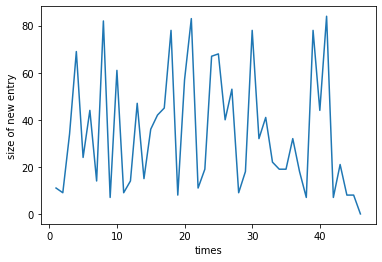

In [130]:
test_09_converters = [
    # GooConverter(app_id=secrets["goo_api_id"]),
    YahooConverter(app_id=secrets["yahoo_app_id"])]

test_09_competition = ConverterCompetition(converters=test_09_converters)
test_09_url = 'https://stream.wikimedia.org/v2/stream/recentchange'

# wikipediaの更新ログをデータセットに変換するイテレータ
def getDataSourceFromWikipedia(limit=None):
  count = 0
  for event in EventSource(test_09_url, last_id=None):
    if event.event == 'message':
        try:
            change = json.loads(event.data)
        except ValueError:
            pass
        else:
            if change["server_name"] == 'ja.wikipedia.org':
                datasource = WikipediaDataSource(title=change["title"])
                datasource.load()
                count +=1
                yield datasource
                if limit != None and count >= limit:
                   break

# datasetの上限100, バッチ処理100characterに設定し、ストリーミングを行う
test_09_batch = CompetionBatch(test_09_competition, streaming_iters=getDataSourceFromWikipedia(limit=100), batch_character_size=100)
test_09_batch.start(show_entry_rates=True) #ストリーミング処理を開始